In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("new-media-user-analysis.csv")

'''data = data.drop(['ID', 'Sex', 'Marital status', 'Education', 'Occupation', 'Settlement size'],axis=1)

plt.scatter(x=data["Age"], y=data["Income"], s=10)
plt.title('Age vs. Income')
plt.xlabel('Age')
plt.ylabel('Income')'''

'data = data.drop([\'ID\', \'Sex\', \'Marital status\', \'Education\', \'Occupation\', \'Settlement size\'],axis=1)\n\nplt.scatter(x=data["Age"], y=data["Income"], s=10)\nplt.title(\'Age vs. Income\')\nplt.xlabel(\'Age\')\nplt.ylabel(\'Income\')'

In [55]:
# 导入因子分析工具
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity,FactorAnalyzer
# 计算 KMO 和巴特利特球形检验
def calculate_kmo_and_bartlett(data):
    # KMO 测试
    kmo_all, kmo_model = calculate_kmo(data)
    
    # 巴特利特球形检验
    test_statistic, p_value = calculate_bartlett_sphericity(data)
    
    return kmo_model, test_statistic, p_value

# 执行函数
kmo_value, bartlett_statistic, bartlett_p_value = calculate_kmo_and_bartlett(data)

# 输出结果
print(f"KMO 值: {kmo_value}")
print(f"巴特利特统计量: {bartlett_statistic}")
print(f"巴特利特p值: {bartlett_p_value}")

# 判断是否适合进行因子分析
if kmo_value > 0.6 and bartlett_p_value < 0.05:
    print("数据适合进行因子分析。")
else:
    print("数据可能不适合进行因子分析。")

KMO 值: 0.6701027460600121
巴特利特统计量: 2158.6463741534753
巴特利特p值: 0.0
数据适合进行因子分析。


In [56]:
def find_neighbors(X, index, eps):
    """
    查找给定点的所有邻近点。

    参数:
    X (numpy.ndarray): 数据集，形状为 (n_samples, n_features)。
    index (int): 当前点的索引。
    eps (float): 邻域半径。

    返回:
    neighbors (list): 邻近点的索引列表。
    """
    neighbors = []
    for i in range(X.shape[0]):
        if np.linalg.norm(X[index] - X[i]) < eps:
            neighbors.append(i)
    return neighbors

def expand_cluster(X, labels, index, neighbors, cluster_id, eps, min_samples):
    """
    扩展当前聚类，递归地查找并标记所有邻近点。

    参数:
    X (numpy.ndarray): 数据集，形状为 (n_samples, n_features)。
    labels (numpy.ndarray): 每个点的标签数组，初始值为 -1 表示未分类，0 表示噪声。
    index (int): 当前点的索引。
    neighbors (list): 当前点的邻近点索引列表。
    cluster_id (int): 当前聚类的 ID。
    eps (float): 邻域半径。
    min_samples (int): 成为核心点所需的最小邻近点数。
    """
    labels[index] = cluster_id
    i = 0
    while i < len(neighbors):
        neighbor = neighbors[i]
        if labels[neighbor] == -1:
            labels[neighbor] = cluster_id
            new_neighbors = find_neighbors(X, neighbor, eps)
            if len(new_neighbors) >= min_samples:
                neighbors.extend(new_neighbors)
        elif labels[neighbor] == 0:
            labels[neighbor] = cluster_id
        i += 1

def dbscan(X, eps, min_samples):
    """
    实现 DBSCAN 聚类算法。

    参数:
    X (numpy.ndarray): 数据集，形状为 (n_samples, n_features)。
    eps (float): 邻域半径。
    min_samples (int): 成为核心点所需的最小邻近点数。

    返回:
    labels (numpy.ndarray): 每个点的标签数组，-1 表示噪声点，其他值表示所属的聚类 ID。
    """
    labels = np.full(X.shape[0], -1)  # 初始化所有点的标签为 -1（未分类）
    cluster_id = 0  # 初始化聚类 ID 为 0

    for i in range(X.shape[0]):
        if labels[i] != -1:
            continue  # 如果点已经被分类，则跳过

        neighbors = find_neighbors(X, i, eps)  # 查找当前点的邻近点

        if len(neighbors) < min_samples:
            labels[i] = 0  # 标记为噪声点
        else:
            cluster_id += 1  # 创建新的聚类
            expand_cluster(X, labels, i, neighbors, cluster_id, eps, min_samples)  # 扩展当前聚类

    return labels

In [57]:
# 加载和预处理数据
data = pd.read_csv("new-media-user-analysis.csv")  # 更新此路径为实际数据集的路径

# 选择需要的数值列
numerical_cols = ["年龄"]  # 定义需要处理的数值列名

# 对年龄和收入进行对数变换
#data['Income'] = np.log(data['Income'])
#data['Age'] = np.log(data['Age'])

# 提取数值列的数据
X = data[numerical_cols].values  # 获取选定列的数据并转换为 NumPy 数组

# 对数据归一化处理
X_normalized = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))  # 使用最小-最大归一化
#X_normalized=X
data['年龄']=X_normalized

print(data.head())  

data = data.drop(['年龄', '性别'],axis=1)

print(data.head())  

   性别        年龄  我尽量每天都定时入睡  我每天三餐时间一致  我不会随意打破作息时间  对我来说品质比价格重要  外出时候宾馆需要很干净  \
0   2  0.190476           4          5            4            4            4   
1   2  0.238095           5          5            3            2            3   
2   1  0.119048           3          4            3            3            3   
3   2  0.119048           4          1            1            1            1   
4   2  0.214286           5          5            2            4            4   

   我的衣服等日用品都是品牌的  我每周都会运动  我很少暴饮暴食  我早睡早起  关注可穿戴设备  新的东西出来想尝试  就算新品贵一些也会买  
0              4        4        4      5        2          2           2  
1              2        3        1      5        2          1           1  
2              3        3        3      3        3          3           2  
3              1        1        1      1        2          3           2  
4              4        4        3      5        1          1           1  
   我尽量每天都定时入睡  我每天三餐时间一致  我不会随意打破作息时间  对我来说品质比价格重要  外出时候宾

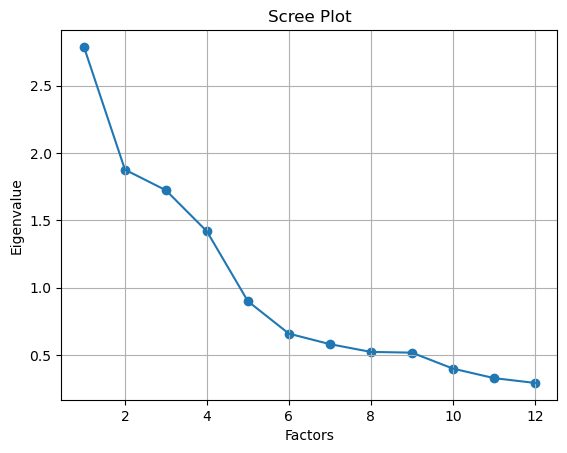

建议保留的因子数量： 4


In [58]:
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity,FactorAnalyzer
fa = FactorAnalyzer(n_factors=data.shape[1]-1, rotation=None)
fa.fit(data)

ev, v = fa.get_eigenvalues()
cumulative_variances = fa.get_factor_variance()

plt.scatter(range(1, data.shape[1]+1), ev)
plt.plot(range(1, data.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
n_factors = sum(ev > 1) #建议保留特征值＞1的点
print("建议保留的因子数量：", n_factors)

In [59]:
fa = FactorAnalyzer(n_factors=4, rotation="varimax") #设定为建议的4，最大方差旋转法
fa.fit(data)
factor_scores = fa.transform(data)
factor_scores #降维后的数据

array([[ 0.8458568 ,  0.15473992, -0.12498904,  1.13514236],
       [-2.19248935, -1.69495043, -1.1826231 ,  1.47278124],
       [-0.21088376, -1.03097857,  0.89123961, -0.02675055],
       ...,
       [ 0.79771333,  0.20736272, -1.07034791, -0.13320241],
       [-0.22427664,  0.31145774,  0.23966378, -0.07131869],
       [-0.28288063,  0.610346  ,  0.16378791,  1.16469023]])

In [60]:
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, index=data.columns, columns=['Factor1', 'Factor2', 'Factor3', 'Factor4'])#,'Factor5'])
loadings_df #显示因子荷载表

,Factor1,Factor2,Factor3,Factor4
我尽量每天都定时入睡,-0.033838,-0.035388,-0.087021,0.331266
我每天三餐时间一致,0.065284,0.084940,0.004901,0.968716
我不会随意打破作息时间,0.057820,0.208337,-0.042838,0.405450
对我来说品质比价格重要,0.074063,0.631851,-0.028928,0.096954
外出时候宾馆需要很干净,0.068638,0.793725,-0.052542,0.064438
我的衣服等日用品都是品牌的,0.113773,0.726426,-0.086553,0.030270
我每周都会运动,0.518576,0.226155,-0.025903,-0.013026
我很少暴饮暴食,0.975843,0.013722,-0.043378,0.020113
我早睡早起,0.660126,0.034378,-0.081454,0.044068
关注可穿戴设备,-0.051317,-0.010207,0.807271,-0.085690


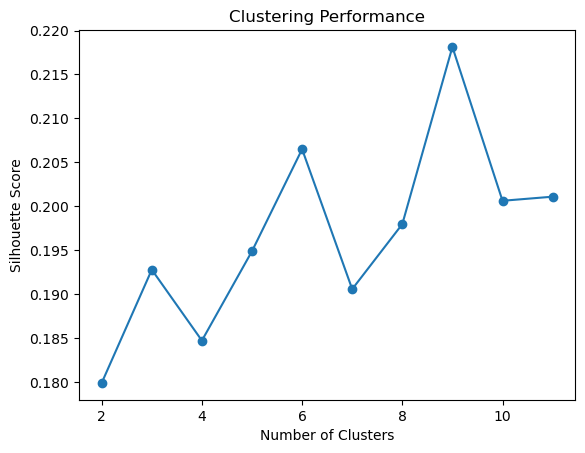

In [61]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans

def auto_cluster(data, n):
    results = []
    for i in range(2, n+1):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(data)
        labels = kmeans.labels_
        score = silhouette_score(data, labels)
        results.append((i, score))
    x = [result[0] for result in results]
    y = [result[1] for result in results]
    plt.plot(x, y, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Clustering Performance')
    plt.show()

auto_cluster(factor_scores, 11) #silhouette_score分数越大越好，看看推荐聚几类

In [62]:
def do_kmeans(n):
    kmeans_obs = KMeans(n_clusters=n)
    obs_clusters = kmeans_obs.fit_predict(factor_scores)+1
    factor_scores_df = pd.DataFrame(factor_scores)
    factor_scores_df.columns=['健康生活习惯','注重品质','创新与消费倾向','规律作息']
    factor_scores_df['类型'] = obs_clusters
    return factor_scores_df,kmeans_obs

In [63]:
# 如果分为4类
factor_scores_df_4 , kmeans_obs= do_kmeans(4)
factor_scores_df_4.groupby('类型').mean().T

类型,1,2,3,4
健康生活习惯,-0.255527,1.089166,-0.781769,-0.074103
注重品质,-1.209647,0.263584,0.555281,-0.225621
创新与消费倾向,-0.831066,-0.249597,-0.352415,0.964592
规律作息,0.308890,0.030728,0.093501,-0.265474


In [64]:
feature_names = ['健康生活习惯','注重品质','创新与消费倾向','规律作息']
factor_scores_df = pd.DataFrame(factor_scores, columns=feature_names)
factor_scores_df

,健康生活习惯,注重品质,创新与消费倾向,规律作息
0,0.845857,0.154740,-0.124989,1.135142
1,-2.192489,-1.694950,-1.182623,1.472781
2,-0.210884,-1.030979,0.891240,-0.026751
3,-2.355155,-3.607023,-0.117504,-3.422858
4,-0.229110,0.085230,-1.557299,1.181502
...,...,...,...,...
671,-1.401176,1.158282,-1.696930,0.003636
672,-0.283114,-0.845796,-1.668781,0.063161
673,0.797713,0.207363,-1.070348,-0.133202
674,-0.224277,0.311458,0.239664,-0.071319


In [65]:

# 计算轮廓系数
silhouette_avg =silhouette_score(factor_scores, factor_scores_df_4['类型']-1)
print(f"平均轮廓系数: {silhouette_avg}")

# 计算 Calinski-Harabasz 指数
calinski_harabasz_score_val = calinski_harabasz_score(factor_scores, factor_scores_df_4['类型']-1)
print(f'Calinski-Harabasz Score: {calinski_harabasz_score_val}')

# 计算 Davies-Bouldin 指数
davies_bouldin_score_val = davies_bouldin_score(factor_scores, factor_scores_df_4['类型']-1)
print(f'Davies-Bouldin Score:{davies_bouldin_score_val}')

cluster_centers = factor_scores_df_4.groupby('类型').mean().T
print("每个簇的中心点:")
print(cluster_centers)




平均轮廓系数: 0.19664306412222743
Calinski-Harabasz Score: 131.39861463118268
Davies-Bouldin Score:1.479928970956744
每个簇的中心点:
类型              1         2         3         4
健康生活习惯  -0.255527  1.089166 -0.781769 -0.074103
注重品质    -1.209647  0.263584  0.555281 -0.225621
创新与消费倾向 -0.831066 -0.249597 -0.352415  0.964592
规律作息     0.308890  0.030728  0.093501 -0.265474


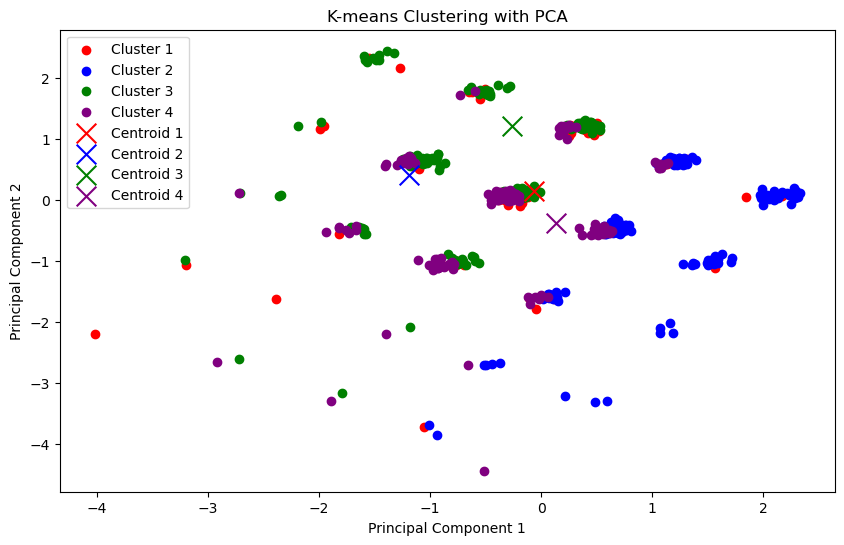

In [66]:
from sklearn.decomposition import PCA
# 进行PCA降维
pca = PCA(n_components=2)  # 降维到2维
factor_scores_pca = pca.fit_transform(factor_scores)
cluster_centers_pca = pca.transform(cluster_centers)

# 绘制聚类结果
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'purple']
for i in range(4):
    plt.scatter(factor_scores_pca[factor_scores_df_4['类型'] == i+1, 0],
                factor_scores_pca[factor_scores_df_4['类型'] == i+1, 1],
                label=f'Cluster {i+1}', color=colors[i])

# 绘制质心
for i, center in enumerate(cluster_centers_pca):
    plt.scatter(center[0], center[1], marker='x', s=200, color=colors[i], label=f'Centroid {i+1}')

plt.title('K-means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

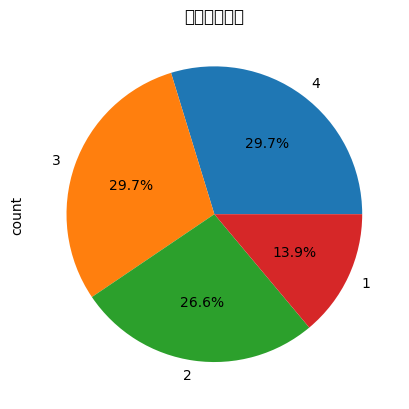

In [67]:
# 每一类人的占比画饼图
type_counts = factor_scores_df_4['类型'].value_counts()
type_counts.plot.pie(autopct='%1.1f%%')
plt.title('各类人的占比')
plt.show()

In [68]:
from sklearn.decomposition import PCA


# PCA 降维
pca = PCA(n_components=3)  # 降维到3维
pca_result = pca.fit_transform(factor_scores_df)

# 获取主成分的载荷
component_loadings = pca.components_

# 创建 DataFrame 以便查看主成分载荷
columns = factor_scores_df.columns
pca_loadings_df = pd.DataFrame(component_loadings, columns=columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

# 打印主成分载荷
print("PCA Component Loadings:")
print(pca_loadings_df)

PCA Component Loadings:
       健康生活习惯      注重品质   创新与消费倾向      规律作息
PC1  0.870871  0.102550 -0.103494  0.469421
PC2 -0.479481  0.090552  0.013645  0.872761
PC3  0.106719 -0.277623  0.951984  0.072550


In [69]:
# 保存为 CSV 文件
factor_scores_df.to_csv('factor_scores.csv', index=False)

In [70]:
factor_scores_df.head()

,健康生活习惯,注重品质,创新与消费倾向,规律作息
0,0.845857,0.154740,-0.124989,1.135142
1,-2.192489,-1.694950,-1.182623,1.472781
2,-0.210884,-1.030979,0.891240,-0.026751
3,-2.355155,-3.607023,-0.117504,-3.422858
4,-0.229110,0.085230,-1.557299,1.181502


In [71]:
factor_scores_df.describe()

,健康生活习惯,注重品质,创新与消费倾向,规律作息
count,6.760000e+02,6.760000e+02,6.760000e+02,6.760000e+02
mean,1.576648e-16,1.051099e-17,1.149639e-16,-3.416071e-16
std,9.787295e-01,8.861923e-01,9.105571e-01,9.746914e-01
min,-2.533630e+00,-4.221263e+00,-1.877033e+00,-3.939783e+00
25%,-3.289702e-01,-4.808235e-01,-4.868943e-01,-1.519404e-01
50%,-2.201280e-01,1.553142e-01,-1.192515e-01,-4.552799e-02
75%,7.819897e-01,3.695826e-01,8.295311e-01,1.031224e+00
max,2.012593e+00,1.880359e+00,2.456040e+00,1.485413e+00


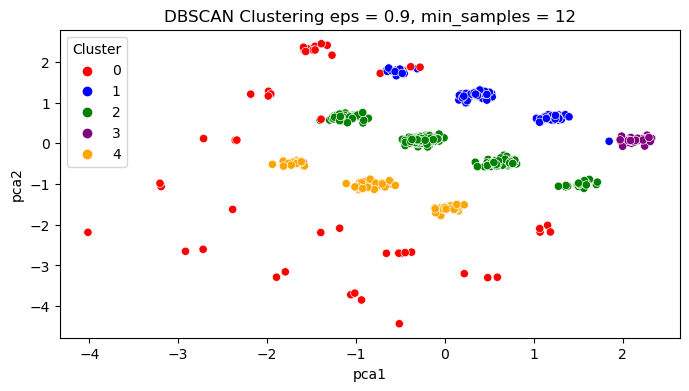

   我尽量每天都定时入睡  我每天三餐时间一致  我不会随意打破作息时间  对我来说品质比价格重要  外出时候宾馆需要很干净  \
0           4          5            4            4            4   
1           5          5            3            2            3   
2           3          4            3            3            3   
3           4          1            1            1            1   
4           5          5            2            4            4   

   我的衣服等日用品都是品牌的  我每周都会运动  我很少暴饮暴食  我早睡早起  关注可穿戴设备  新的东西出来想尝试  就算新品贵一些也会买  
0              4        4        4      5        2          2           2  
1              2        3        1      5        2          1           1  
2              3        3        3      3        3          3           2  
3              1        1        1      1        2          3           2  
4              4        4        3      5        1          1           1  
Silhouette Coefficient for eps=0.9, min_samples=12: -0.15533181325883857
Calinski-Harabasz Score for eps=0.9, min_samples=12: 1.3094572679933

In [72]:
pca_result_df = pd.DataFrame(pca_result, columns=['pca1','pca2','pca3'])

# 定义不同的 eps 和 min_samples 值
eps_values = [0.9]
min_samples_values = [12]

# 定义聚类名称和颜色
clusters_name = ['DBSCAN']
cluster_colors = ['#FF0000', '#0000FF', '#008000', '#800080', '#FFA500', '#008080']

# 遍历不同的 eps 和 min_samples 值，进行 DBSCAN 聚类
for eps in eps_values:
    for min_samples in min_samples_values:
        # 进行 DBSCAN 聚类
        cluster_labels = dbscan(pca_result, eps, min_samples)#.values

        # 将聚类标签添加回原始数据框
        pca_result_df['Cluster'] = cluster_labels

        # 可视化聚类结果（仅适用于二维数据）
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x='pca1', y='pca2', hue='Cluster', data=pca_result_df, palette=cluster_colors[:len(set(cluster_labels))])
        plt.title(f'DBSCAN Clustering eps = {eps}, min_samples = {min_samples}')
        plt.xlabel('pca1')
        plt.ylabel('pca2')
        plt.show()
        # 打印聚类标签数量
        #print(f'Number of clusters for eps={eps}, min_samples={min_samples}: {len(set(cluster_labels))}')

        print(data.head())

        # 计算轮廓系数
        if len(set(cluster_labels)) > 1:  # 至少有两个簇才能计算轮廓系数
            silhouette_avg = silhouette_score(X_normalized, cluster_labels)
            print(f'Silhouette Coefficient for eps={eps}, min_samples={min_samples}: {silhouette_avg}')

        # 计算 Calinski-Harabasz 指数
        calinski_harabasz_score_val = calinski_harabasz_score(X_normalized, cluster_labels)
        print(f'Calinski-Harabasz Score for eps={eps}, min_samples={min_samples}: {calinski_harabasz_score_val}')

        # 计算 Davies-Bouldin 指数
        davies_bouldin_score_val = davies_bouldin_score(X_normalized, cluster_labels)
        print(f'Davies-Bouldin Score for eps={eps}, min_samples={min_samples}: {davies_bouldin_score_val}')

       

平均轮廓系数: 0.12198447146388722
Calinski-Harabasz Score: 75.95286189157427
Davies-Bouldin Score: 1.9363197688810942


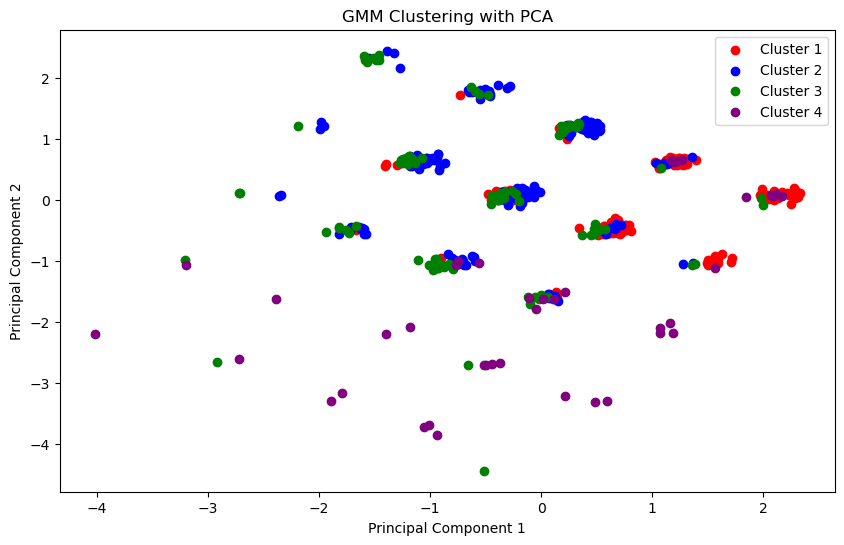

In [73]:
from sklearn.mixture import GaussianMixture
# 进行GMM聚类
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(factor_scores_df)
labels = gmm.predict(factor_scores_df)



# 计算评价指标（可选）
silhouette_avg = silhouette_score(factor_scores_df, labels)
print(f"平均轮廓系数: {silhouette_avg}")

calinski_harabasz_score_val = calinski_harabasz_score(factor_scores_df, labels)
print(f'Calinski-Harabasz Score: {calinski_harabasz_score_val}')

davies_bouldin_score_val = davies_bouldin_score(factor_scores_df, labels)
print(f'Davies-Bouldin Score: {davies_bouldin_score_val}')

# 进行PCA降维
pca = PCA(n_components=2)
df_pca = pca.fit_transform(factor_scores_df)

# 将聚类结果添加到DataFrame中
factor_scores_df['类型'] = labels + 1
# 绘制聚类结果
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'purple']
for i in range(4):
    plt.scatter(df_pca[factor_scores_df['类型'] == i+1, 0], df_pca[factor_scores_df['类型'] == i+1, 1], label=f'Cluster {i+1}', color=colors[i])

plt.title('GMM Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

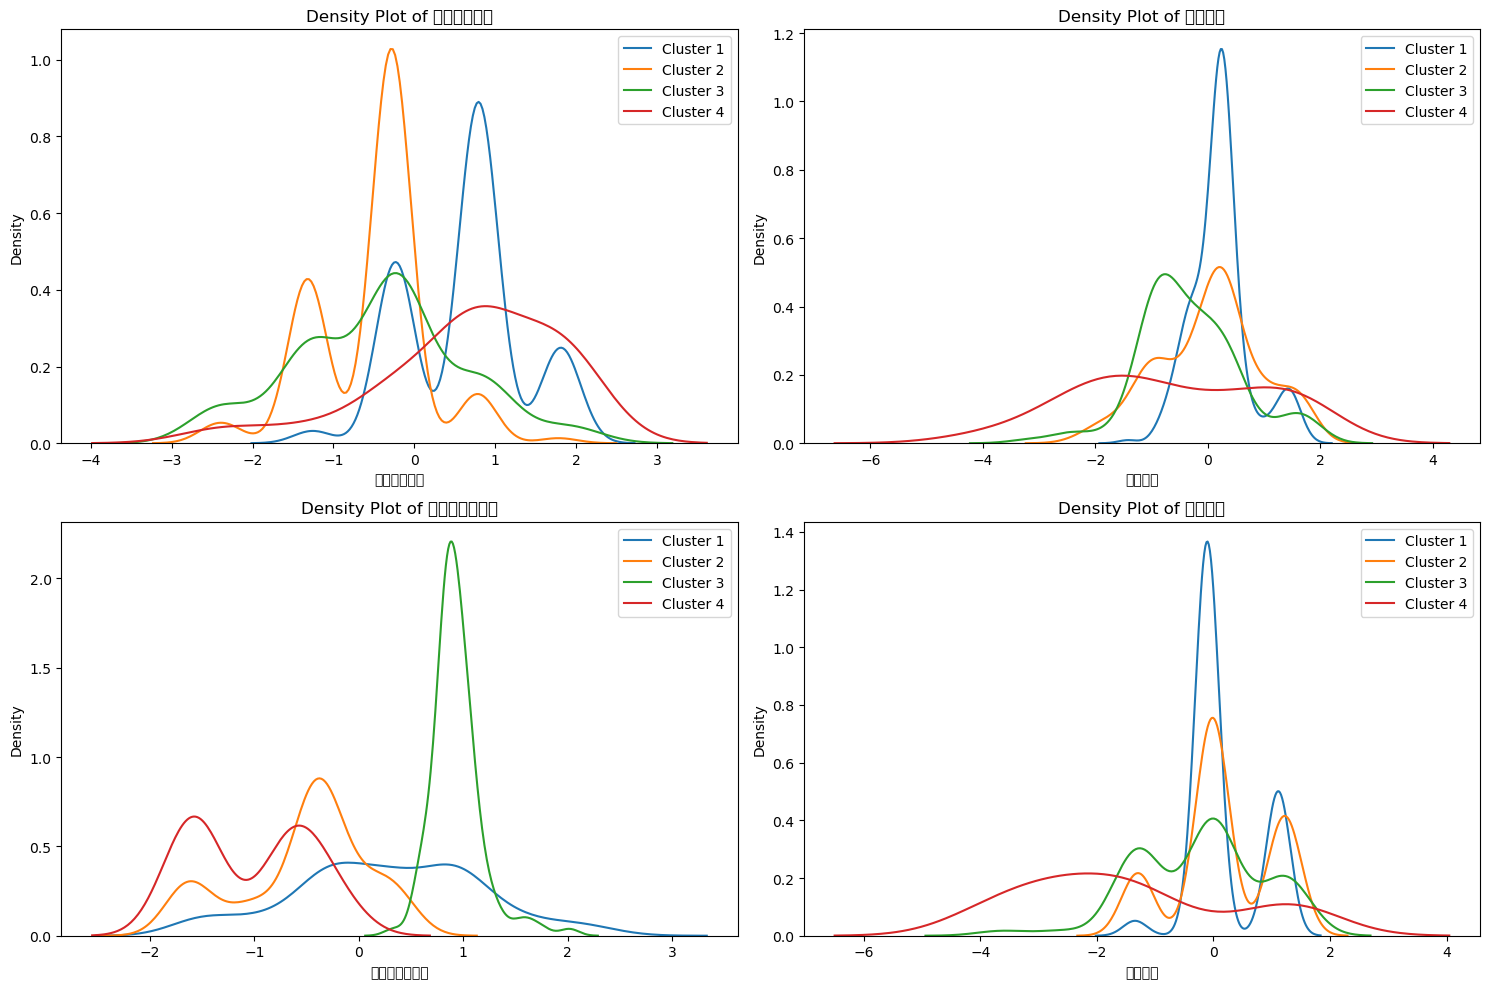

In [74]:
# 创建一个新的DataFrame，包含原始特征和聚类标签
df_with_labels = factor_scores_df

# 绘制密度图
plt.figure(figsize=(15, 10))

features = ['健康生活习惯','注重品质','创新与消费倾向','规律作息']
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    for j in range(1, 5):
        sns.kdeplot(df_with_labels[df_with_labels['类型'] == j][feature], label=f'Cluster {j}')
    plt.title(f'Density Plot of {feature}')
    plt.legend()

plt.tight_layout()
plt.show()

In [75]:
factor_scores_df

,健康生活习惯,注重品质,创新与消费倾向,规律作息,类型
0,0.845857,0.154740,-0.124989,1.135142,1
1,-2.192489,-1.694950,-1.182623,1.472781,2
2,-0.210884,-1.030979,0.891240,-0.026751,3
3,-2.355155,-3.607023,-0.117504,-3.422858,4
4,-0.229110,0.085230,-1.557299,1.181502,2
...,...,...,...,...,...
671,-1.401176,1.158282,-1.696930,0.003636,2
672,-0.283114,-0.845796,-1.668781,0.063161,2
673,0.797713,0.207363,-1.070348,-0.133202,1
674,-0.224277,0.311458,0.239664,-0.071319,1


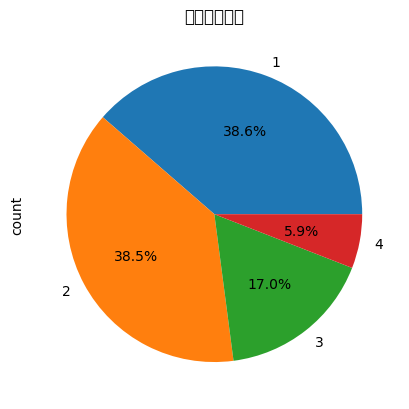

In [76]:
# 每一类人的占比画饼图
type_counts = factor_scores_df['类型'].value_counts()
type_counts.plot.pie(autopct='%1.1f%%')
plt.title('各类人的占比')
plt.show()

平均轮廓系数: -0.0007859170465118892
Calinski-Harabasz Score: 7.93099410680623
Davies-Bouldin Score: 7.010935965030743


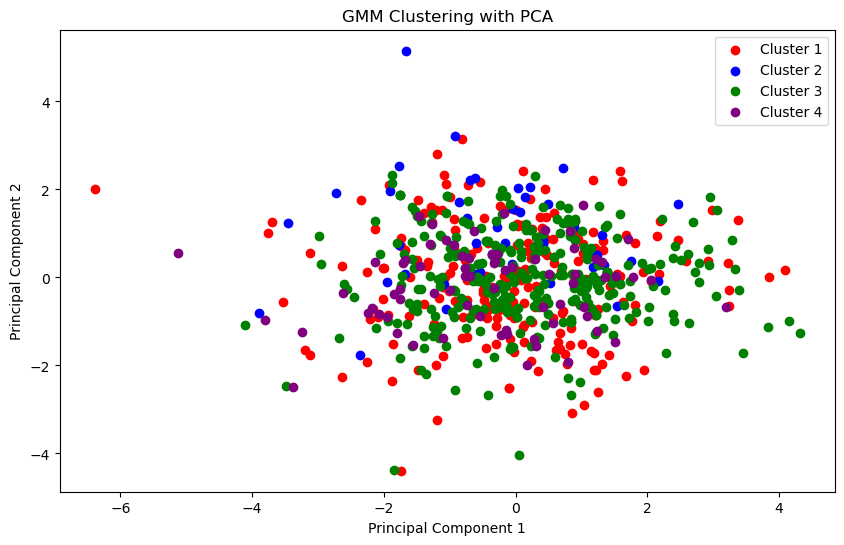

In [77]:
from sklearn.mixture import GaussianMixture
# 进行GMM聚类
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(data)
labels = gmm.predict(data)



# 计算评价指标（可选）
silhouette_avg = silhouette_score(data, labels)
print(f"平均轮廓系数: {silhouette_avg}")

calinski_harabasz_score_val = calinski_harabasz_score(data, labels)
print(f'Calinski-Harabasz Score: {calinski_harabasz_score_val}')

davies_bouldin_score_val = davies_bouldin_score(data, labels)
print(f'Davies-Bouldin Score: {davies_bouldin_score_val}')

# 进行PCA降维
pca = PCA(n_components=2)
df_pca = pca.fit_transform(data)

# 将聚类结果添加到DataFrame中
data['类型'] = labels + 1
# 绘制聚类结果
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'purple']
for i in range(4):
    plt.scatter(df_pca[data['类型'] == i+1, 0], df_pca[data['类型'] == i+1, 1], label=f'Cluster {i+1}', color=colors[i])

plt.title('GMM Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()